In [14]:
import numpy as np
import matplotlib.pyplot as plt
from fishsense_imwut.camera import reconstruct_points
from scipy import odr

## Setup of Simulation
The following reasonable defaults that match the systems we tested against.

In [15]:
IMAGE_WIDTH, IMAGE_HEIGHT = 4014, 3016
FOCAL_LENGTH_PX = 2850

IMAGE_WIDTH, IMAGE_HEIGHT, FOCAL_LENGTH_PX

(4014, 3016, 2850)

In [16]:
camera_intrinsics = np.array([
    [FOCAL_LENGTH_PX, 0, IMAGE_WIDTH / 2],
    [0, FOCAL_LENGTH_PX, IMAGE_HEIGHT / 2],
    [0, 0, 1]
])
inverted_camera_intrinsics = np.linalg.inv(camera_intrinsics)

camera_intrinsics, inverted_camera_intrinsics

(array([[2.850e+03, 0.000e+00, 2.007e+03],
        [0.000e+00, 2.850e+03, 1.508e+03],
        [0.000e+00, 0.000e+00, 1.000e+00]]),
 array([[ 3.50877193e-04,  0.00000000e+00, -7.04210526e-01],
        [ 0.00000000e+00,  3.50877193e-04, -5.29122807e-01],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]))

In [17]:
laser_position = np.array([-0.04, -0.11, 0])
laser_direction = np.array([1e-10, 1e-10, 1])

laser_params = np.concatenate([laser_direction, laser_position[:2]])

laser_position, laser_direction, laser_params

(array([-0.04, -0.11,  0.  ]),
 array([1.e-10, 1.e-10, 1.e+00]),
 array([ 1.0e-10,  1.0e-10,  1.0e+00, -4.0e-02, -1.1e-01]))

## Next we setup data we can use for testing

In [18]:
STEP_COUNT = 1000
t = np.linspace(0.5, 30, STEP_COUNT)

STEP_COUNT, t

(1000,
 array([ 0.5       ,  0.52952953,  0.55905906,  0.58858859,  0.61811812,
         0.64764765,  0.67717718,  0.70670671,  0.73623624,  0.76576577,
         0.7952953 ,  0.82482482,  0.85435435,  0.88388388,  0.91341341,
         0.94294294,  0.97247247,  1.002002  ,  1.03153153,  1.06106106,
         1.09059059,  1.12012012,  1.14964965,  1.17917918,  1.20870871,
         1.23823824,  1.26776777,  1.2972973 ,  1.32682683,  1.35635636,
         1.38588589,  1.41541542,  1.44494494,  1.47447447,  1.504004  ,
         1.53353353,  1.56306306,  1.59259259,  1.62212212,  1.65165165,
         1.68118118,  1.71071071,  1.74024024,  1.76976977,  1.7992993 ,
         1.82882883,  1.85835836,  1.88788789,  1.91741742,  1.94694695,
         1.97647648,  2.00600601,  2.03553554,  2.06506507,  2.09459459,
         2.12412412,  2.15365365,  2.18318318,  2.21271271,  2.24224224,
         2.27177177,  2.3013013 ,  2.33083083,  2.36036036,  2.38988989,
         2.41941942,  2.44894895,  2.4784784

In [19]:
p = laser_position[:, np.newaxis] + t[np.newaxis, :] * laser_direction[:, np.newaxis]

p

array([[-0.04      , -0.04      , -0.04      , ..., -0.04      ,
        -0.04      , -0.04      ],
       [-0.11      , -0.11      , -0.11      , ..., -0.11      ,
        -0.11      , -0.11      ],
       [ 0.5       ,  0.52952953,  0.55905906, ..., 29.94094094,
        29.97047047, 30.        ]], shape=(3, 1000))

In [20]:
s = p / p[2, :]
s = camera_intrinsics @ s

s

array([[1.77900000e+03, 1.79171456e+03, 1.80308594e+03, ...,
        2.00319250e+03, 2.00319626e+03, 2.00320000e+03],
       [8.81000000e+02, 9.15965029e+02, 9.47236348e+02, ...,
        1.49752939e+03, 1.49753970e+03, 1.49755000e+03],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]], shape=(3, 1000))

In [21]:
s_pixel = np.round(s)

s_pixel

array([[1.779e+03, 1.792e+03, 1.803e+03, ..., 2.003e+03, 2.003e+03,
        2.003e+03],
       [8.810e+02, 9.160e+02, 9.470e+02, ..., 1.498e+03, 1.498e+03,
        1.498e+03],
       [1.000e+00, 1.000e+00, 1.000e+00, ..., 1.000e+00, 1.000e+00,
        1.000e+00]], shape=(3, 1000))

In [22]:
def f(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]

In [23]:
np.random.seed(0)

calibrations_by_stds = []
stds = [
    (0.0, 0.0),
    (0.5, 0.5),
    (1.0, 1.0),
    (2.0, 2.0),
    (3.0, 5.0), # Real world estimate
    (5.0, 5.0),
    (8.0, 8.0),
    (10.0, 10.0),
]

z_errors_by_stds = []
for idx, (x_std, y_std) in enumerate(stds):
    s_noisy = s.copy()
    s_noisy[0, :] += np.random.normal(0, x_std, s.shape[1])
    s_noisy[1, :] += np.random.normal(0, y_std, s.shape[1])

    model = odr.Model(f)
    data = odr.Data(s_noisy[0, :], s_noisy[1, :])
    odr_run = odr.ODR(data, model, beta0=[1.0, 1.0])
    results = odr_run.run()

    s_reconstructed = np.zeros_like(s_noisy)
    s_reconstructed[0, :] = results.xplus
    s_reconstructed[1, :] = results.y
    s_reconstructed[2, :] = 1
    p_reconstructed = reconstruct_points(s_reconstructed, inverted_camera_intrinsics, laser_position, laser_direction)

    z_error = np.abs(p_reconstructed[2, :] - p[2, :]) / p[2, :] * 100
    z_errors_by_stds.append(((x_std, y_std), z_error))

/tmp/ipykernel_1346721/1491506354.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + [f"{x_std},{y_std}" for x_std, y_std in stds])


Text(0, 0.5, 'Z Percent Error (%)')

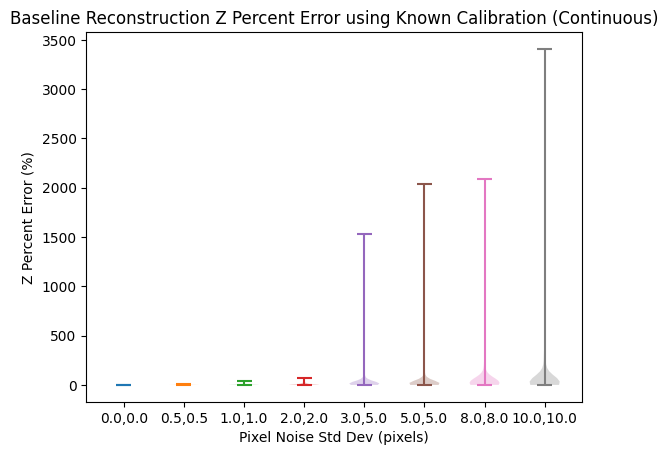

In [24]:
fig, ax = plt.subplots()

for idx, ((x_std, y_std), z_error) in enumerate(z_errors_by_stds):
    ax.violinplot(z_error, positions=[idx])

ax.set_xticklabels([""] + [f"{x_std},{y_std}" for x_std, y_std in stds])
ax.set_title("Baseline Reconstruction Z Percent Error using Known Calibration (Continuous)")
ax.set_xlabel("Pixel Noise Std Dev (pixels)")
ax.set_ylabel("Z Percent Error (%)")

/tmp/ipykernel_1346721/3363381109.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([""] + [f"{x_std},{y_std}" for x_std, y_std in stds[:5]])


Text(0, 0.5, 'Z Percent Error (%)')

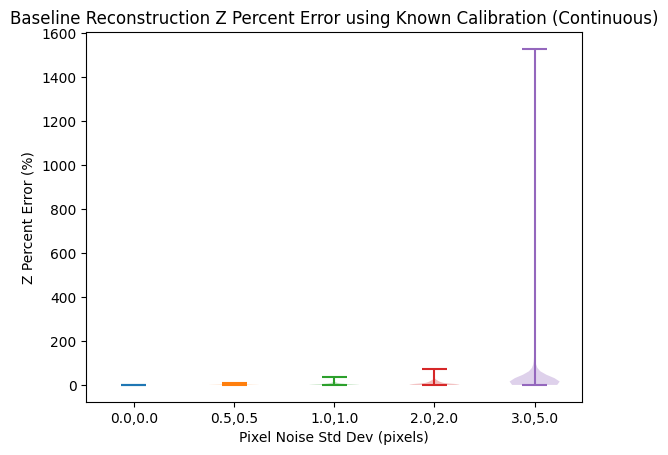

In [ ]:
fig, ax = plt.subplots()

for idx, ((x_std, y_std), z_error) in enumerate(z_errors_by_stds[:5]):
    ax.violinplot(z_error, positions=[idx])

ax.set_xticklabels([""] + [f"{x_std},{y_std}" for x_std, y_std in stds[:5]])
ax.set_title("Baseline Reconstruction Z Percent Error using Known Calibration with ODR Correction (Continuous)")
ax.set_xlabel("Pixel Noise Std Dev (pixels)")
ax.set_ylabel("Z Percent Error (%)")